In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Import models for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Load data
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

# Separate features and target variable
def preprocess_data(train, test, target_column='DiagPeriodL90D'):
    X = train.drop(columns=[target_column, 'patient_id'])
    y = train[target_column]
    X_test = test.drop(columns=['patient_id'])
    return X, y, X_test

# Define preprocessors
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return preprocessor

# Initialize models
def initialize_models():
    return {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
        'LightGBM': LGBMClassifier(random_state=42),
        'SVC': SVC(probability=True, random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'GaussianNB': GaussianNB(),
        'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
        'Voting Classifier': VotingClassifier(estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
            ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
            ('cat', CatBoostClassifier(verbose=0, random_state=42)),
            ('lgb', LGBMClassifier(random_state=42))
        ], voting='soft')
    }

# Evaluate models
def evaluate_models(models, preprocessor, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scorer = make_scorer(roc_auc_score, needs_proba=True)
    results = {}

    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring=scorer, n_jobs=-1)
        results[name] = {
            'Mean ROC-AUC': cv_scores.mean(),
            'Std Dev': cv_scores.std(),
            'Scores': cv_scores
        }
        print(f"{name}: Mean ROC-AUC = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")
    return pd.DataFrame(results).T

# Train best model on full data and make predictions
def train_best_model_and_predict(best_model_name, models, preprocessor, X, y, X_test, test_data):
    best_model = models[best_model_name]
    final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_model)])
    final_pipeline.fit(X, y)

    predictions = final_pipeline.predict_proba(X_test)[:, 1]  # Probability of DiagPeriodL90D=1
    submission = pd.DataFrame({
        'patient_id': test_data['patient_id'],
        'DiagPeriodL90D': predictions
    })
    submission.to_csv('submission.csv', index=False)
    print(f"Submission file created as 'submission.csv' with best model: {best_model_name}")

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import HistGradientBoostingClassifier  # Ensuring this is imported if used

# Custom transformer to convert sparse matrix to dense matrix
class SparseToDenseTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.toarray() if hasattr(X, 'toarray') else X

# Function to check if model needs dense data
def needs_dense_data(model):
    # Add models that require dense data here
    return isinstance(model, (GaussianNB, HistGradientBoostingClassifier))

# Adjusted evaluate_models function
def evaluate_models(models, preprocessor, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scorer = make_scorer(roc_auc_score, needs_proba=True)
    results = {}

    for name, model in models.items():
        if needs_dense_data(model):
            # Wrap models needing dense data with SparseToDenseTransformer
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('to_dense', SparseToDenseTransformer()),
                ('classifier', model)
            ])
        else:
            # Standard pipeline without conversion for other models
            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

        # Evaluate using cross-validation
        cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring=scorer, n_jobs=-1)

        results[name] = {
            'Mean ROC-AUC': cv_scores.mean(),
            'Std Dev': cv_scores.std(),
            'Scores': cv_scores
        }
        print(f"{name}: Mean ROC-AUC = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

    return pd.DataFrame(results).T

In [19]:
if __name__ == "__main__":
    # Paths to data files
    train_path = 'processed_train_data.csv'
    test_path = 'processed_test_data.csv'

    # Load datasets
    train_data, test_data = load_data(train_path, test_path)

    # Preprocess data
    X, y, X_test = preprocess_data(train_data, test_data)

    # Create preprocessor
    preprocessor = create_preprocessor(X)

    # Initialize models
    models = initialize_models()

    # Evaluate models and get results
    model_results = evaluate_models(models, preprocessor, X, y)

    # Select the best model by highest ROC-AUC mean
    best_model_name = model_results['Mean ROC-AUC'].idxmax()
    print(f"\nBest model: {best_model_name} with Mean ROC-AUC: {model_results['Mean ROC-AUC'].max():.4f}")

    # Train the best model and predict on test set
    train_best_model_and_predict(best_model_name, models, preprocessor, X, y, X_test, test_data)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Logistic Regression: Mean ROC-AUC = 0.7606, Std = 0.0051
Random Forest: Mean ROC-AUC = 0.7841, Std = 0.0042
Gradient Boosting: Mean ROC-AUC = 0.7993, Std = 0.0038
XGBoost: Mean ROC-AUC = 0.7965, Std = 0.0045
CatBoost: Mean ROC-AUC = 0.8026, Std = 0.0044


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


LightGBM: Mean ROC-AUC = 0.7969, Std = 0.0058


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting
param_grid = {
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 1.0]
}

# Create a GradientBoostingClassifier instance
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create a pipeline with the preprocessor and GradientBoostingClassifier
gb_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', gb_model)])

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(gb_pipeline, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X, y)

# Print the results for each hyperparameter combination
print("Gradient Boosting Hyperparameter Tuning Results:")
results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_test_score', 'std_test_score']])


# Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Hyperparameters: {best_params}")
print(f"Best Mean ROC-AUC Score: {best_score:.4f}")

Gradient Boosting Hyperparameter Tuning Results:
                                               params  mean_test_score  \
0   {'classifier__learning_rate': 0.01, 'classifie...         0.758230   
1   {'classifier__learning_rate': 0.01, 'classifie...         0.758230   
2   {'classifier__learning_rate': 0.01, 'classifie...         0.758236   
3   {'classifier__learning_rate': 0.01, 'classifie...         0.768243   
4   {'classifier__learning_rate': 0.01, 'classifie...         0.768254   
5   {'classifier__learning_rate': 0.01, 'classifie...         0.768250   
6   {'classifier__learning_rate': 0.01, 'classifie...         0.786525   
7   {'classifier__learning_rate': 0.01, 'classifie...         0.786712   
8   {'classifier__learning_rate': 0.01, 'classifie...         0.787032   
9   {'classifier__learning_rate': 0.1, 'classifier...         0.799470   
10  {'classifier__learning_rate': 0.1, 'classifier...         0.799276   
11  {'classifier__learning_rate': 0.1, 'classifier...         0

In [ ]:

# Define the parameter grid for CatBoost
param_grid_catboost = {
    'classifier__iterations': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__depth': [4, 6],
    'classifier__random_strength': [0.5, 1.0],  # Added random_strength
    'classifier__bagging_temperature': [0.0, 0.5]  # Added bagging_temperature
}

# Create a CatBoostClassifier instance
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

# Create a pipeline with the preprocessor and CatBoostClassifier
catboost_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', catboost_model)])

# Perform GridSearchCV to find the best hyperparameters
grid_search_catboost = GridSearchCV(catboost_pipeline, param_grid_catboost, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search_catboost.fit(X, y)

# Print the results for each hyperparameter combination
print("\nCatBoost Hyperparameter Tuning Results:")
results_catboost = pd.DataFrame(grid_search_catboost.cv_results_)
print(results_catboost[['params', 'mean_test_score', 'std_test_score']])

# Get the best hyperparameters and score for CatBoost
best_params_catboost = grid_search_catboost.best_params_
best_score_catboost = grid_search_catboost.best_score_

print(f"\nBest Hyperparameters for CatBoost: {best_params_catboost}")
print(f"Best Mean ROC-AUC Score for CatBoost: {best_score_catboost:.4f}")


CatBoost Hyperparameter Tuning Results:
                                               params  mean_test_score  \
0   {'classifier__bagging_temperature': 0.0, 'clas...         0.788666   
1   {'classifier__bagging_temperature': 0.0, 'clas...         0.789551   
2   {'classifier__bagging_temperature': 0.0, 'clas...         0.802563   
3   {'classifier__bagging_temperature': 0.0, 'clas...         0.801909   
4   {'classifier__bagging_temperature': 0.0, 'clas...         0.794577   
5   {'classifier__bagging_temperature': 0.0, 'clas...         0.793403   
6   {'classifier__bagging_temperature': 0.0, 'clas...         0.803177   
7   {'classifier__bagging_temperature': 0.0, 'clas...         0.804307   
8   {'classifier__bagging_temperature': 0.0, 'clas...         0.793626   
9   {'classifier__bagging_temperature': 0.0, 'clas...         0.792958   
10  {'classifier__bagging_temperature': 0.0, 'clas...         0.804366   
11  {'classifier__bagging_temperature': 0.0, 'clas...         0.802596 

Evaluating Gradient Boosting Classifier:
Precision: 0.7902813299232737
Recall: 0.9554730983302412
F1 Score: 0.8650615901455767
ROC AUC: 0.7996862993902225
AUC-PR: 0.8192524910153984


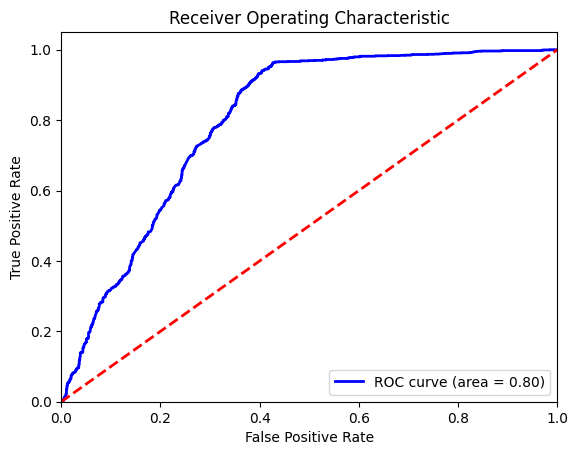

                                Feature  Importance
0                      num__patient_age    0.027051
1                              num__bmi    0.005941
2                   num__N02xOzonexPM25    0.005684
3                            num__clust    0.000599
4                        num__is_female    0.001366
..                                  ...         ...
920  num__payer_type_MEDICARE ADVANTAGE    0.000119
921             num__patient_race_Black    0.001852
922          num__patient_race_Hispanic    0.000644
923             num__patient_race_Other    0.000162
924             num__patient_race_White    0.001300

[925 rows x 2 columns]


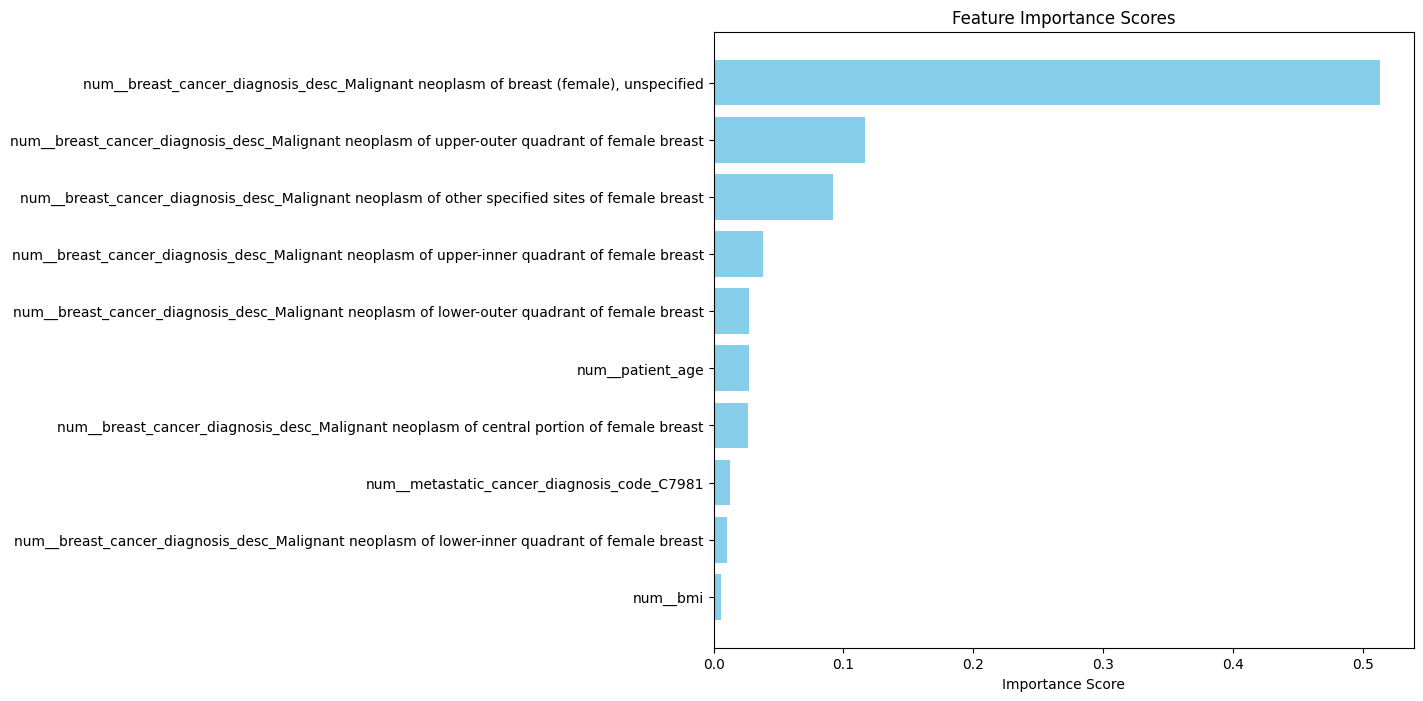

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


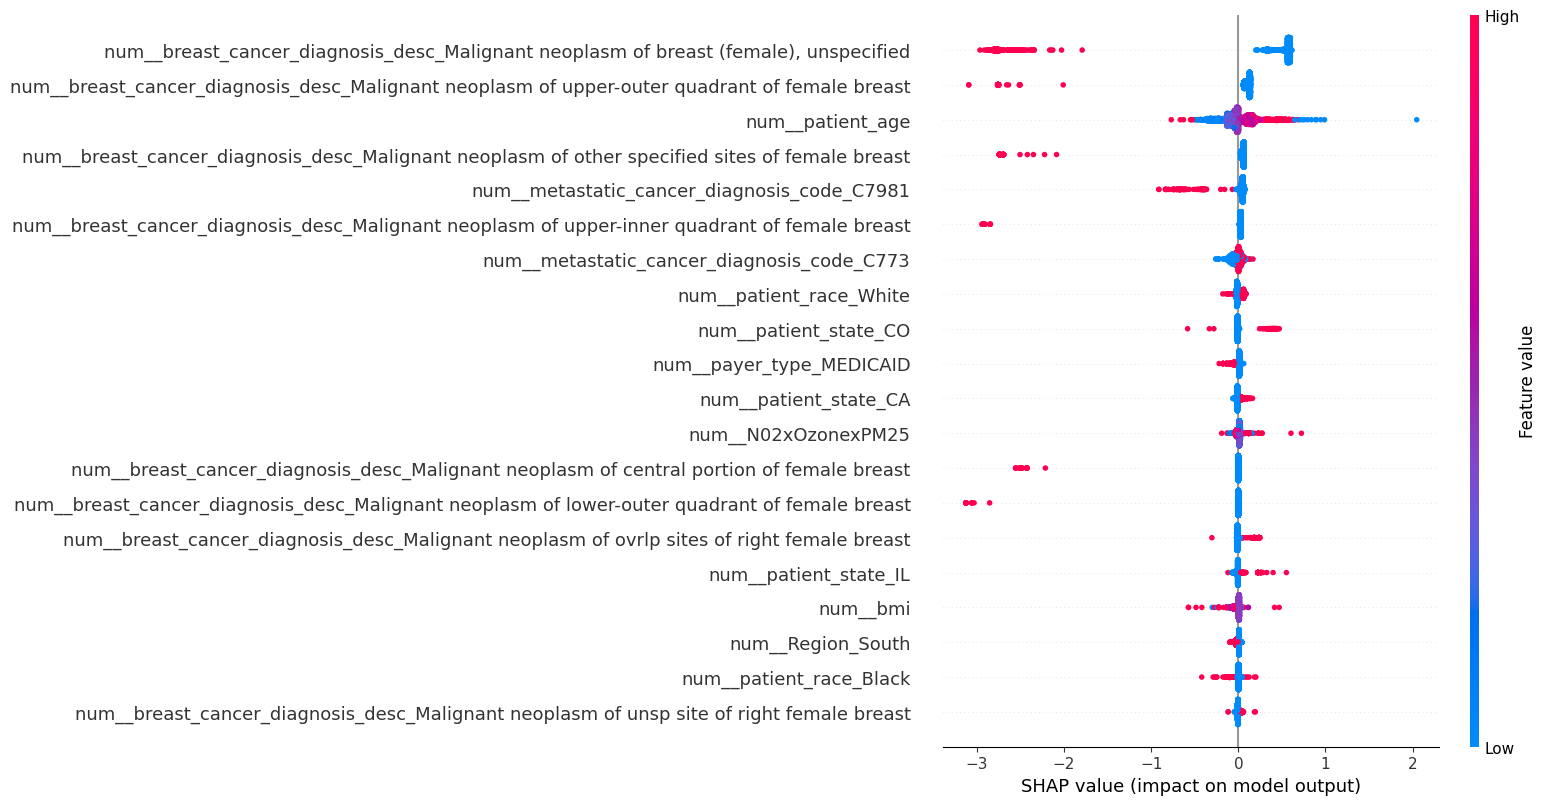


Evaluating CatBoost Classifier:
Precision: 0.7903307888040713
Recall: 0.9604205318491033
F1 Score: 0.8671133445002792
ROC AUC: 0.8054492263226534
AUC-PR: 0.8292935181348552


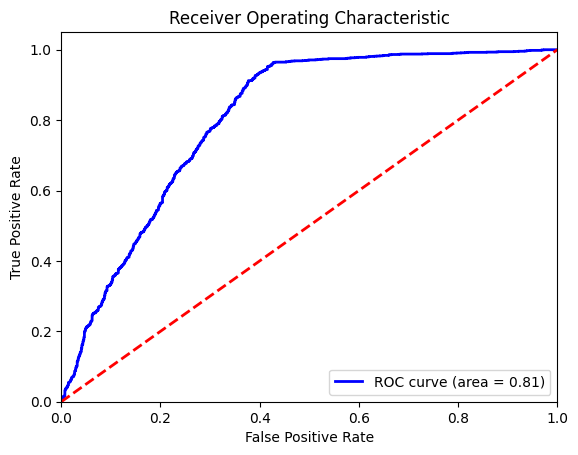

                                Feature  Importance
0                      num__patient_age    5.078467
1                              num__bmi    1.279245
2                   num__N02xOzonexPM25    1.199903
3                            num__clust    0.661815
4                        num__is_female    0.139161
..                                  ...         ...
920  num__payer_type_MEDICARE ADVANTAGE    0.068651
921             num__patient_race_Black    0.448326
922          num__patient_race_Hispanic    0.126861
923             num__patient_race_Other    0.041556
924             num__patient_race_White    1.080384

[925 rows x 2 columns]


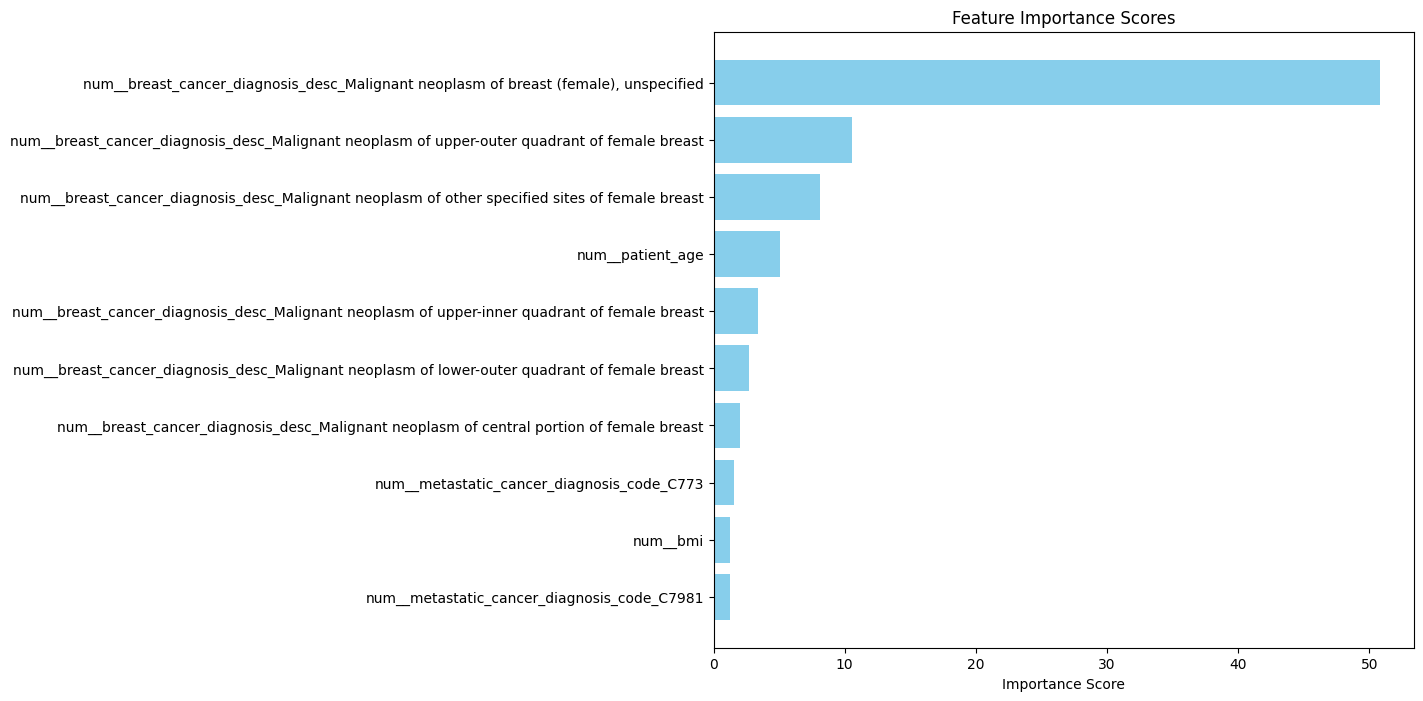

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


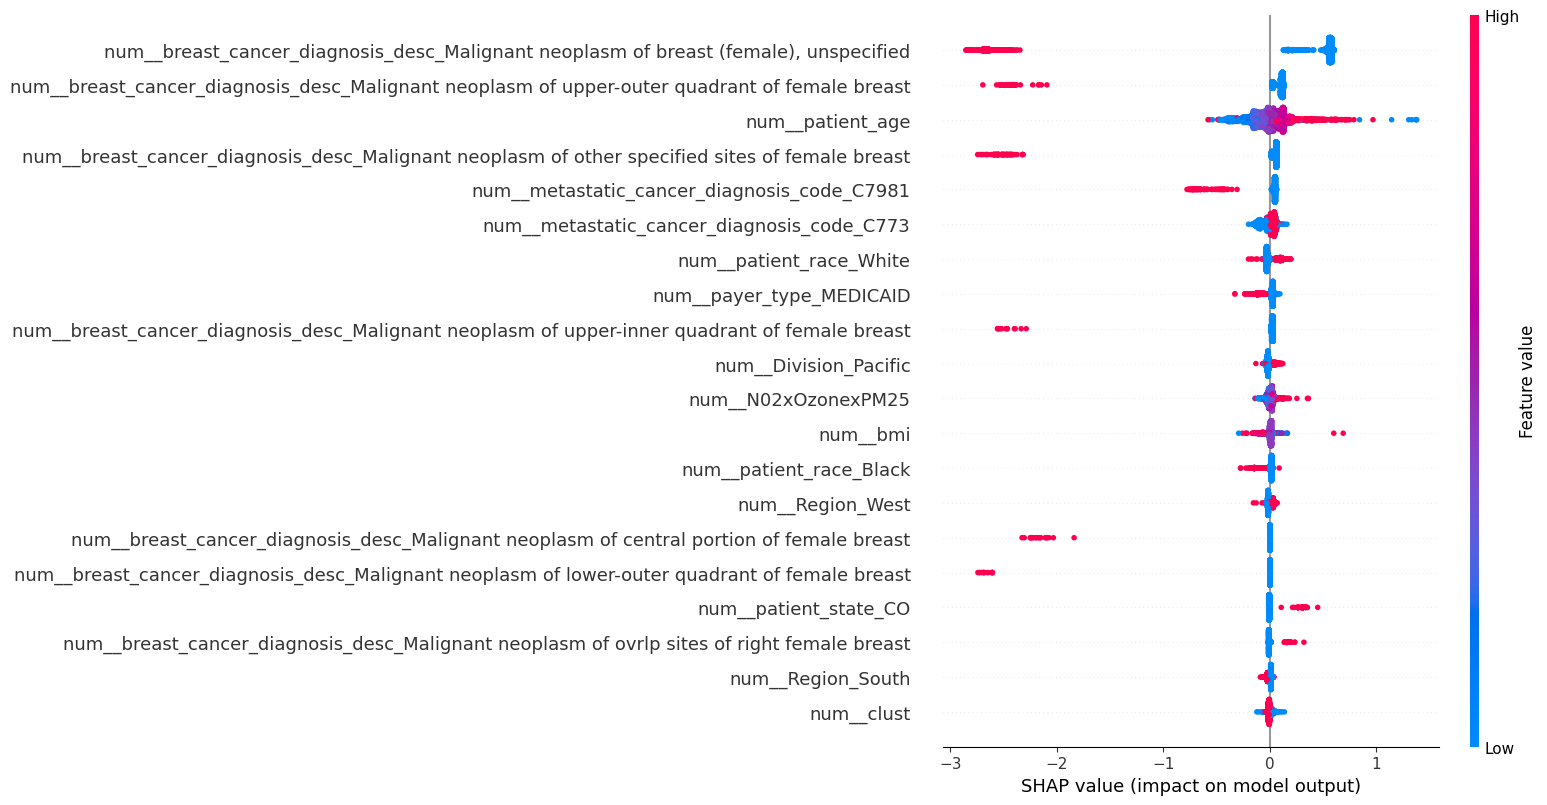

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, average_precision_score
import shap
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 读取数据
train_path = 'processed_train_data.csv'
train_data = pd.read_csv(train_path)

# 划分数据集
def preprocess_data(train, test, target_column='DiagPeriodL90D'):
    X = train.drop(columns=[target_column, 'patient_id'])
    y = train[target_column]
    X_test = test.drop(columns=[target_column, 'patient_id'])
    y_test = test[target_column]
    return X, y, X_test, y_test

# 切割数据集
train, test = train_test_split(train_data, test_size=0.2, random_state=42)
X_train, y_train, X_test, y_test = preprocess_data(train, test)

# 创建预处理器
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return preprocessor

# 训练模型并评估
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # 创建预处理器
    preprocessor = create_preprocessor(X_train)

    # 预处理训练集和测试集
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # 创建完整的管道
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # 训练模型
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # 计算指标
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    pr_auc = average_precision_score(y_test, y_prob)

    # 输出结果
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)
    print("AUC-PR:", pr_auc)

    # 绘制 ROC 曲线
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # 特征重要性分数
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        feature_names = preprocessor.get_feature_names_out()

        # 创建数据框并筛选出重要性分数大于0的特征
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        print(importance_df)
        # 保留前十个特征
        importance_df = importance_df.nlargest(10, 'Importance')
        #importance_df = importance_df[importance_df['Importance'] > 0.01]  # 只保留重要性大于0.01的特征
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # 绘制特征重要性图
        plt.figure(figsize=(10, 8))  # 增加高度以便留出空间
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Importance Score')
        plt.title('Feature Importance Scores')
        #plt.xlim(0, 0.5)  # 设置横轴范围为0到0.2
        plt.gca().invert_yaxis()  # 反转y轴

        # 设置竖轴特征名称的间距
        plt.yticks(fontsize=10)  # 调整字体大小
        plt.subplots_adjust(left=0.2)  # 调整左侧间距以便显示完整特征名称
        plt.show()


    # SHAP 值
    explainer = shap.Explainer(pipeline.named_steps['classifier'], X_train_processed)
    shap_values = explainer(X_test_processed)
    shap.summary_plot(shap_values, X_test_processed, feature_names=preprocessor.get_feature_names_out())

# 使用 Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, min_samples_split=10)
print("Evaluating Gradient Boosting Classifier:")
evaluate_model(gb_model, X_train, y_train, X_test, y_test)

# 使用 CatBoost
cat_model = CatBoostClassifier(bagging_temperature=0.0, depth=6, iterations=100, learning_rate=0.1, random_strength=0.5, verbose=0)
print("\nEvaluating CatBoost Classifier:")
evaluate_model(cat_model, X_train, y_train, X_test, y_test)
